In [1]:
from pyspark.sql import SparkSession

# SparkSession 생성
spark = SparkSession.builder.appName("BankMarketing-EDA").getOrCreate()

In [2]:
file_path = './bank.csv'

df = spark.read.csv(file_path, inferSchema = True, header = True,sep = ';')
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [3]:
df.show()

+---+-------------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|          job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+-------------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
| 30|   unemployed|married|  primary|     no|   1787|     no|  no|cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|
| 33|     services|married|secondary|     no|   4789|    yes| yes|cellular| 11|  may|     220|       1|  339|       4| failure| no|
| 35|   management| single| tertiary|     no|   1350|    yes|  no|cellular| 16|  apr|     185|       1|  330|       1| failure| no|
| 30|   management|married| tertiary|     no|   1476|    yes| yes| unknown|  3|  jun|     199|       4|   -1|       0| unknown| no|
| 59|  blue-collar|married|secondary|     no|      0|    yes|  no| unknown| 

In [33]:
from pyspark.sql.functions import floor, col

df = df.withColumn('age_group', floor(col('age') / 10) * 10)
df.select('age', 'age_group').show(10)

+---+---------+
|age|age_group|
+---+---------+
| 30|       30|
| 33|       30|
| 35|       30|
| 30|       30|
| 59|       50|
| 35|       30|
| 36|       30|
| 39|       30|
| 41|       40|
| 43|       40|
+---+---------+
only showing top 10 rows



In [26]:
# 1) month, y별 count
month_y_count = df.groupBy('month', 'y').count()

# 2) month별 총 count (윈도우 함수 사용)
window_spec = Window.partitionBy('month')
month_y_count = month_y_count.withColumn('month_total', F.sum('count').over(window_spec))

# 3) 비율 계산
month_y_count = month_y_count.withColumn('ratio', F.col('count') / F.col('month_total'))

month_y_count.show()

+-----+---+-----+-----------+-------------------+
|month|  y|count|month_total|              ratio|
+-----+---+-----+-----------+-------------------+
|  apr| no|  237|        293| 0.8088737201365188|
|  apr|yes|   56|        293|0.19112627986348124|
|  aug|yes|   79|        633|0.12480252764612954|
|  aug| no|  554|        633| 0.8751974723538705|
|  dec| no|   11|         20|               0.55|
|  dec|yes|    9|         20|               0.45|
|  feb|yes|   38|        222|0.17117117117117117|
|  feb| no|  184|        222| 0.8288288288288288|
|  jan| no|  132|        148| 0.8918918918918919|
|  jan|yes|   16|        148|0.10810810810810811|
|  jul| no|  645|        706| 0.9135977337110481|
|  jul|yes|   61|        706|0.08640226628895184|
|  jun|yes|   55|        531|0.10357815442561205|
|  jun| no|  476|        531|  0.896421845574388|
|  mar| no|   28|         49| 0.5714285714285714|
|  mar|yes|   21|         49|0.42857142857142855|
|  may| no| 1305|       1398| 0.9334763948497854|


In [32]:
from pyspark.sql import functions as F

# pdays와 y별 count 구하기
pdays_y_count = df.groupBy('pdays', 'y').count()

# pdays별 총합 구하기
pdays_total = pdays_y_count.groupBy('pdays').agg(F.sum('count').alias('total'))

# join해서 비율 계산
joined = pdays_y_count.join(pdays_total, on='pdays')
result = joined.withColumn('ratio', F.col('count') / F.col('total'))

# y가 'yes'인 데이터만 필터링해서 성공률만 보기
success_ratio = result.filter(result.y == 'yes').select('pdays', 'count', 'total', 'ratio').orderBy('pdays')

success_ratio.show(100)


+-----+-----+-----+-------------------+
|pdays|count|total|              ratio|
+-----+-----+-----+-------------------+
|   -1|  337| 3705|0.09095816464237517|
|    1|    2|    2|                1.0|
|   38|    1|    1|                1.0|
|   56|    1|    1|                1.0|
|   57|    1|    1|                1.0|
|   60|    1|    1|                1.0|
|   63|    1|    1|                1.0|
|   64|    3|    3|                1.0|
|   73|    1|    1|                1.0|
|   78|    1|    4|               0.25|
|   80|    1|    2|                0.5|
|   84|    1|    4|               0.25|
|   85|    1|    6|0.16666666666666666|
|   86|    1|    1|                1.0|
|   87|    2|    6| 0.3333333333333333|
|   88|    1|    3| 0.3333333333333333|
|   89|    2|    3| 0.6666666666666666|
|   90|    3|    5|                0.6|
|   91|    5|   11|0.45454545454545453|
|   92|   11|   12| 0.9166666666666666|
|   93|    1|    4|               0.25|
|   94|    3|    8|              0.375|


In [31]:
from pyspark.sql import functions as F

# 1) campaign과 y별 count
campaign_y_count = df.groupBy('campaign', 'y').count()

# 2) campaign별 총 연락 횟수 (sum)
campaign_total = campaign_y_count.groupBy('campaign').agg(F.sum('count').alias('total'))

# 3) campaign_y_count와 campaign_total 조인
joined = campaign_y_count.join(campaign_total, on='campaign')

# 4) 비율 계산 (각 campaign별 y 상태 비율)
result = joined.withColumn('ratio', F.col('count') / F.col('total'))

result.orderBy('campaign', 'y').show(150)

+--------+---+-----+-----+--------------------+
|campaign|  y|count|total|               ratio|
+--------+---+-----+-----+--------------------+
|       1| no| 1494| 1734|  0.8615916955017301|
|       1|yes|  240| 1734|  0.1384083044982699|
|       2| no| 1126| 1264|  0.8908227848101266|
|       2|yes|  138| 1264| 0.10917721518987342|
|       3| no|  501|  558|  0.8978494623655914|
|       3|yes|   57|  558| 0.10215053763440861|
|       4| no|  282|  325|  0.8676923076923077|
|       4|yes|   43|  325| 0.13230769230769232|
|       5| no|  158|  167|  0.9461077844311377|
|       5|yes|    9|  167| 0.05389221556886228|
|       6| no|  139|  155|   0.896774193548387|
|       6|yes|   16|  155|  0.1032258064516129|
|       7| no|   69|   75|                0.92|
|       7|yes|    6|   75|                0.08|
|       8| no|   52|   56|  0.9285714285714286|
|       8|yes|    4|   56| 0.07142857142857142|
|       9| no|   28|   30|  0.9333333333333333|
|       9|yes|    2|   30| 0.06666666666

In [4]:
from pyspark.sql.functions import mean, stddev, min, max, count

df.groupBy("y").agg(
    count("age").alias("count"),
    mean("age").alias("avg_age"),
    stddev("age").alias("stddev_age"),
    min("age").alias("min_age"),
    max("age").alias("max_age")
).show()

+---+-----+-----------------+------------------+-------+-------+
|  y|count|          avg_age|        stddev_age|min_age|max_age|
+---+-----+-----------------+------------------+-------+-------+
| no| 4000|           40.998|10.188397659186446|     19|     86|
|yes|  521|42.49136276391555|13.115772297009253|     19|     87|
+---+-----+-----------------+------------------+-------+-------+



In [5]:
from pyspark.sql.functions import when, col

df = df.withColumn(
    "age_group",
    when((col("age") < 10), "0대")
    .when((col("age") < 20), "10대")
    .when((col("age") < 30), "20대")
    .when((col("age") < 40), "30대")
    .when((col("age") < 50), "40대")
    .when((col("age") < 60), "50대")
    .when((col("age") < 70), "60대")
    .when((col("age") < 80), "70대")
    .otherwise("80대 이상")
)
age_y_dist = df.groupBy("age_group", "y").count().orderBy("age_group", "y")
age_y_dist.show()

+---------+---+-----+
|age_group|  y|count|
+---------+---+-----+
|     10대| no|    2|
|     10대|yes|    2|
|     20대| no|  406|
|     20대|yes|   72|
|     30대| no| 1623|
|     30대|yes|  185|
|     40대| no| 1080|
|     40대|yes|  123|
|     50대| no|  770|
|     50대|yes|   84|
|     60대| no|   82|
|     60대|yes|   31|
|     70대| no|   29|
|     70대|yes|   18|
|80대 이상| no|    8|
|80대 이상|yes|    6|
+---------+---+-----+



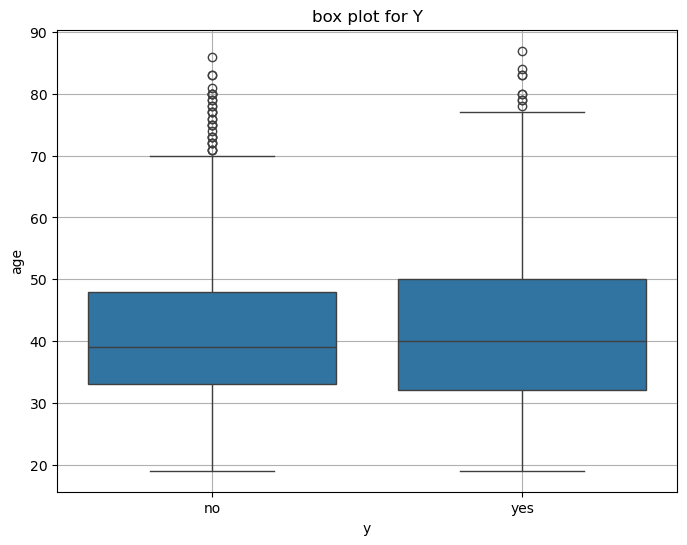

In [6]:
# 1. 필요한 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Spark DataFrame에서 필요한 컬럼만 선택
df_pd = df.select("y", "age").toPandas()

# 3. y가 범주형(str)이라면 필요 시 변환
df_pd["y"] = df_pd["y"].astype(str)

# 5. 박스플롯 그리기
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_pd, x="y", y="age")
plt.title("box plot for Y")
plt.xlabel("y")
plt.ylabel("age")
plt.grid(True)
plt.show()

In [7]:
from pyspark.sql.functions import col, round, sum as spark_sum

# 1. job별 y별 count
job_y_count = df.groupBy("job", "y").count()

# 2. job별 전체 count
job_total = df.groupBy("job").count().withColumnRenamed("count", "job_total")

# 3. job별 y별 count와 job별 전체 count 조인
job_y_ratio = job_y_count.join(job_total, on="job")

# 4. y별 비율 계산
job_y_ratio = job_y_ratio.withColumn(
    "y_ratio_in_job",
    round(col("count") / col("job_total"), 3)
)

# 5. 정렬
job_y_ratio = job_y_ratio.orderBy("job", "y")

job_y_ratio.show()

+-------------+---+-----+---------+--------------+
|          job|  y|count|job_total|y_ratio_in_job|
+-------------+---+-----+---------+--------------+
|       admin.| no|  420|      478|         0.879|
|       admin.|yes|   58|      478|         0.121|
|  blue-collar| no|  877|      946|         0.927|
|  blue-collar|yes|   69|      946|         0.073|
| entrepreneur| no|  153|      168|         0.911|
| entrepreneur|yes|   15|      168|         0.089|
|    housemaid| no|   98|      112|         0.875|
|    housemaid|yes|   14|      112|         0.125|
|   management| no|  838|      969|         0.865|
|   management|yes|  131|      969|         0.135|
|      retired| no|  176|      230|         0.765|
|      retired|yes|   54|      230|         0.235|
|self-employed| no|  163|      183|         0.891|
|self-employed|yes|   20|      183|         0.109|
|     services| no|  379|      417|         0.909|
|     services|yes|   38|      417|         0.091|
|      student| no|   65|      

In [8]:
from pyspark.sql.functions import col, count, sum

# 1. marital과 y별로 count
marital_y_count = df.groupBy('marital', 'y').count()

# 2. marital별 전체 count 구하기
marital_total = df.groupBy('marital').count().withColumnRenamed('count', 'total_count')

# 3. 두 데이터프레임 join
joined = marital_y_count.join(marital_total, on='marital')

# 4. y별 marital 내 비율 계산
result = joined.withColumn('ratio', col('count') / col('total_count'))

# 결과 출력
result.select('marital', 'y', 'count', 'total_count', 'ratio').orderBy('marital', 'y').show()

+--------+---+-----+-----------+-------------------+
| marital|  y|count|total_count|              ratio|
+--------+---+-----+-----------+-------------------+
|divorced| no|  451|        528| 0.8541666666666666|
|divorced|yes|   77|        528|0.14583333333333334|
| married| no| 2520|       2797|  0.900965319985699|
| married|yes|  277|       2797|0.09903468001430103|
|  single| no| 1029|       1196| 0.8603678929765887|
|  single|yes|  167|       1196|0.13963210702341136|
+--------+---+-----+-----------+-------------------+



In [11]:
df.groupBy("education").count().orderBy("count", ascending=False).show()

+---------+-----+
|education|count|
+---------+-----+
|secondary| 2306|
| tertiary| 1350|
|  primary|  678|
|  unknown|  187|
+---------+-----+



In [21]:
df.groupBy("contact").count().orderBy("count", ascending=False).show()

+---------+-----+
|  contact|count|
+---------+-----+
| cellular| 2896|
|  unknown| 1324|
|telephone|  301|
+---------+-----+



In [14]:
# 1. marital과 y별로 count
marital_y_count = df.groupBy('education', 'y').count()

# 2. marital별 전체 count 구하기
marital_total = df.groupBy('education').count().withColumnRenamed('count', 'total_count')

# 3. 두 데이터프레임 join
joined = marital_y_count.join(marital_total, on='education')

# 4. y별 marital 내 비율 계산
result = joined.withColumn('ratio', col('count') / col('total_count'))

# 결과 출력
result.select('education', 'y', 'count', 'total_count', 'ratio').orderBy('education', 'y').show()

+---------+---+-----+-----------+-------------------+
|education|  y|count|total_count|              ratio|
+---------+---+-----+-----------+-------------------+
|  primary| no|  614|        678| 0.9056047197640118|
|  primary|yes|   64|        678| 0.0943952802359882|
|secondary| no| 2061|       2306|  0.893755420641804|
|secondary|yes|  245|       2306|  0.106244579358196|
| tertiary| no| 1157|       1350|  0.857037037037037|
| tertiary|yes|  193|       1350|0.14296296296296296|
|  unknown| no|  168|        187| 0.8983957219251337|
|  unknown|yes|   19|        187|0.10160427807486631|
+---------+---+-----+-----------+-------------------+



In [20]:
from pyspark.sql.functions import avg

# y별 평균 balance 계산
df.groupBy("y").agg(avg("balance").alias("avg_balance")).show()

+---+------------------+
|  y|       avg_balance|
+---+------------------+
| no|        1403.21175|
|yes|1571.9558541266795|
+---+------------------+



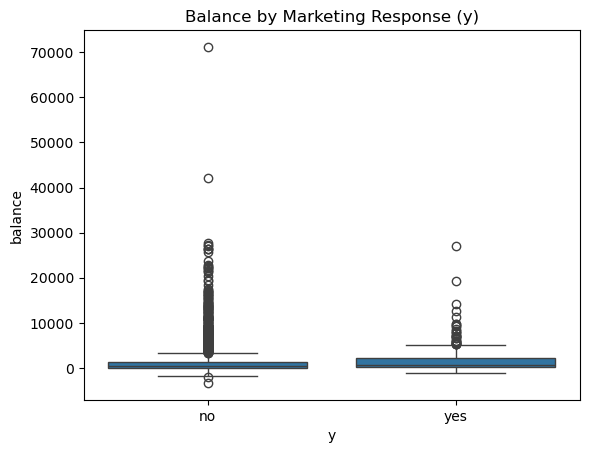

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='y', y='balance', data=df.toPandas())
plt.title("Balance by Marketing Response (y)")
plt.show()

In [ ]:
from pyspark.sql.functions import floor, col

df = df.withColumn('age_group', floor(col('age') / 10) * 10)
df = df.drop("y",'day','age')

df.printSchema()

In [34]:
spark.stop()